# Preprocess CRC data

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import InSituData, InSituExperiment, CACHE
import scanpy as sc
from tqdm import tqdm
import anndata
import pandas as pd

## Reload after proseg addition

In [3]:
#adata_path = Path("D:/ColorectalCancer/analysis/adata_export/")
adata_path = Path("out/adata_export_proseg_rounded.h5ad")
adata = sc.read(adata_path)

c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
adata

AnnData object with n_obs × n_vars = 1018411 × 280
    obs: 'original_cell_id', 'centroid_x', 'centroid_y', 'centroid_z', 'fov', 'cluster', 'volume', 'scale', 'population', 'n_genes_by_counts', 'total_counts', 'n_counts', 'n_genes', 'uid'
    obsm: 'spatial'
    layers: 'counts'

### Add ensembl IDs

Info about how to convert gene names to ensembl IDs was retrieved from [HGNC](https://www.genenames.org).

In [ ]:
df = pd.read_csv("./csv/gene_to_ensemblid.csv", index_col=0)
gene_to_ensembl_dict = df.to_dict()["gene_ids"]

In [6]:
adata.var["ensembl_ids"] = [gene_to_ensembl_dict[elem] for elem in adata.var_names]

In [7]:
adata.var = adata.var.reset_index(names="gene_names").set_index("ensembl_ids")

In [8]:
adata

AnnData object with n_obs × n_vars = 1018411 × 280
    obs: 'original_cell_id', 'centroid_x', 'centroid_y', 'centroid_z', 'fov', 'cluster', 'volume', 'scale', 'population', 'n_genes_by_counts', 'total_counts', 'n_counts', 'n_genes', 'uid'
    var: 'gene_names'
    obsm: 'spatial'
    layers: 'counts'

## Load sampled reference

In notebook [CRC03](./CRC03_celltypist_prepare_reference.ipynb) the reference was prepared and differently sized samples of the data were saved. One of the samples is loaded in the following cell.

In [10]:
ref_path = Path(f"../data/zenodo/crc_atlas_sampled_max5000.h5ad")

In [11]:
reference = sc.read(ref_path)

In [12]:
reference

AnnData object with n_obs × n_vars = 125438 × 28476
    obs: 'dataset', 'medical_condition', 'cancer_type', 'sample_id', 'sample_type', 'tumor_source', 'replicate', 'sample_tissue', 'anatomic_region', 'anatomic_location', 'tumor_stage', 'tumor_stage_TNM', 'tumor_stage_TNM_T', 'tumor_stage_TNM_N', 'tumor_stage_TNM_M', 'tumor_size', 'tumor_dimensions', 'tumor_grade', 'histological_type', 'microsatellite_status', 'mismatch_repair_deficiency_status', 'MLH1_promoter_methylation_status', 'MLH1_status', 'KRAS_status', 'BRAF_status', 'APC_status', 'TP53_status', 'PIK3CA_status', 'SMAD4_status', 'NRAS_status', 'MSH6_status', 'FBXW7_status', 'NOTCH1_status', 'MSH2_status', 'PMS2_status', 'POLE_status', 'ERBB2_status', 'STK11_status', 'HER2_status', 'CTNNB1_status', 'BRAS_status', 'patient_id', 'sex', 'age', 'treatment_status_before_resection', 'treatment_drug', 'treatment_response', 'RECIST', 'platform', 'platform_fine', 'cellranger_version', 'reference_genome', 'matrix_type', 'enrichment_cell_t

In [13]:
len(set(adata.var_names) & set(reference.var_names))

280

## Filter genes in reference

In [14]:
reference = reference[:, adata.var_names].copy()

In [15]:
reference

AnnData object with n_obs × n_vars = 125438 × 280
    obs: 'dataset', 'medical_condition', 'cancer_type', 'sample_id', 'sample_type', 'tumor_source', 'replicate', 'sample_tissue', 'anatomic_region', 'anatomic_location', 'tumor_stage', 'tumor_stage_TNM', 'tumor_stage_TNM_T', 'tumor_stage_TNM_N', 'tumor_stage_TNM_M', 'tumor_size', 'tumor_dimensions', 'tumor_grade', 'histological_type', 'microsatellite_status', 'mismatch_repair_deficiency_status', 'MLH1_promoter_methylation_status', 'MLH1_status', 'KRAS_status', 'BRAF_status', 'APC_status', 'TP53_status', 'PIK3CA_status', 'SMAD4_status', 'NRAS_status', 'MSH6_status', 'FBXW7_status', 'NOTCH1_status', 'MSH2_status', 'PMS2_status', 'POLE_status', 'ERBB2_status', 'STK11_status', 'HER2_status', 'CTNNB1_status', 'BRAS_status', 'patient_id', 'sex', 'age', 'treatment_status_before_resection', 'treatment_drug', 'treatment_response', 'RECIST', 'platform', 'platform_fine', 'cellranger_version', 'reference_genome', 'matrix_type', 'enrichment_cell_typ

### Remove cells with zero counts

In [16]:
reference = reference[reference.layers["counts"].toarray().sum(axis=1) > 0].copy()

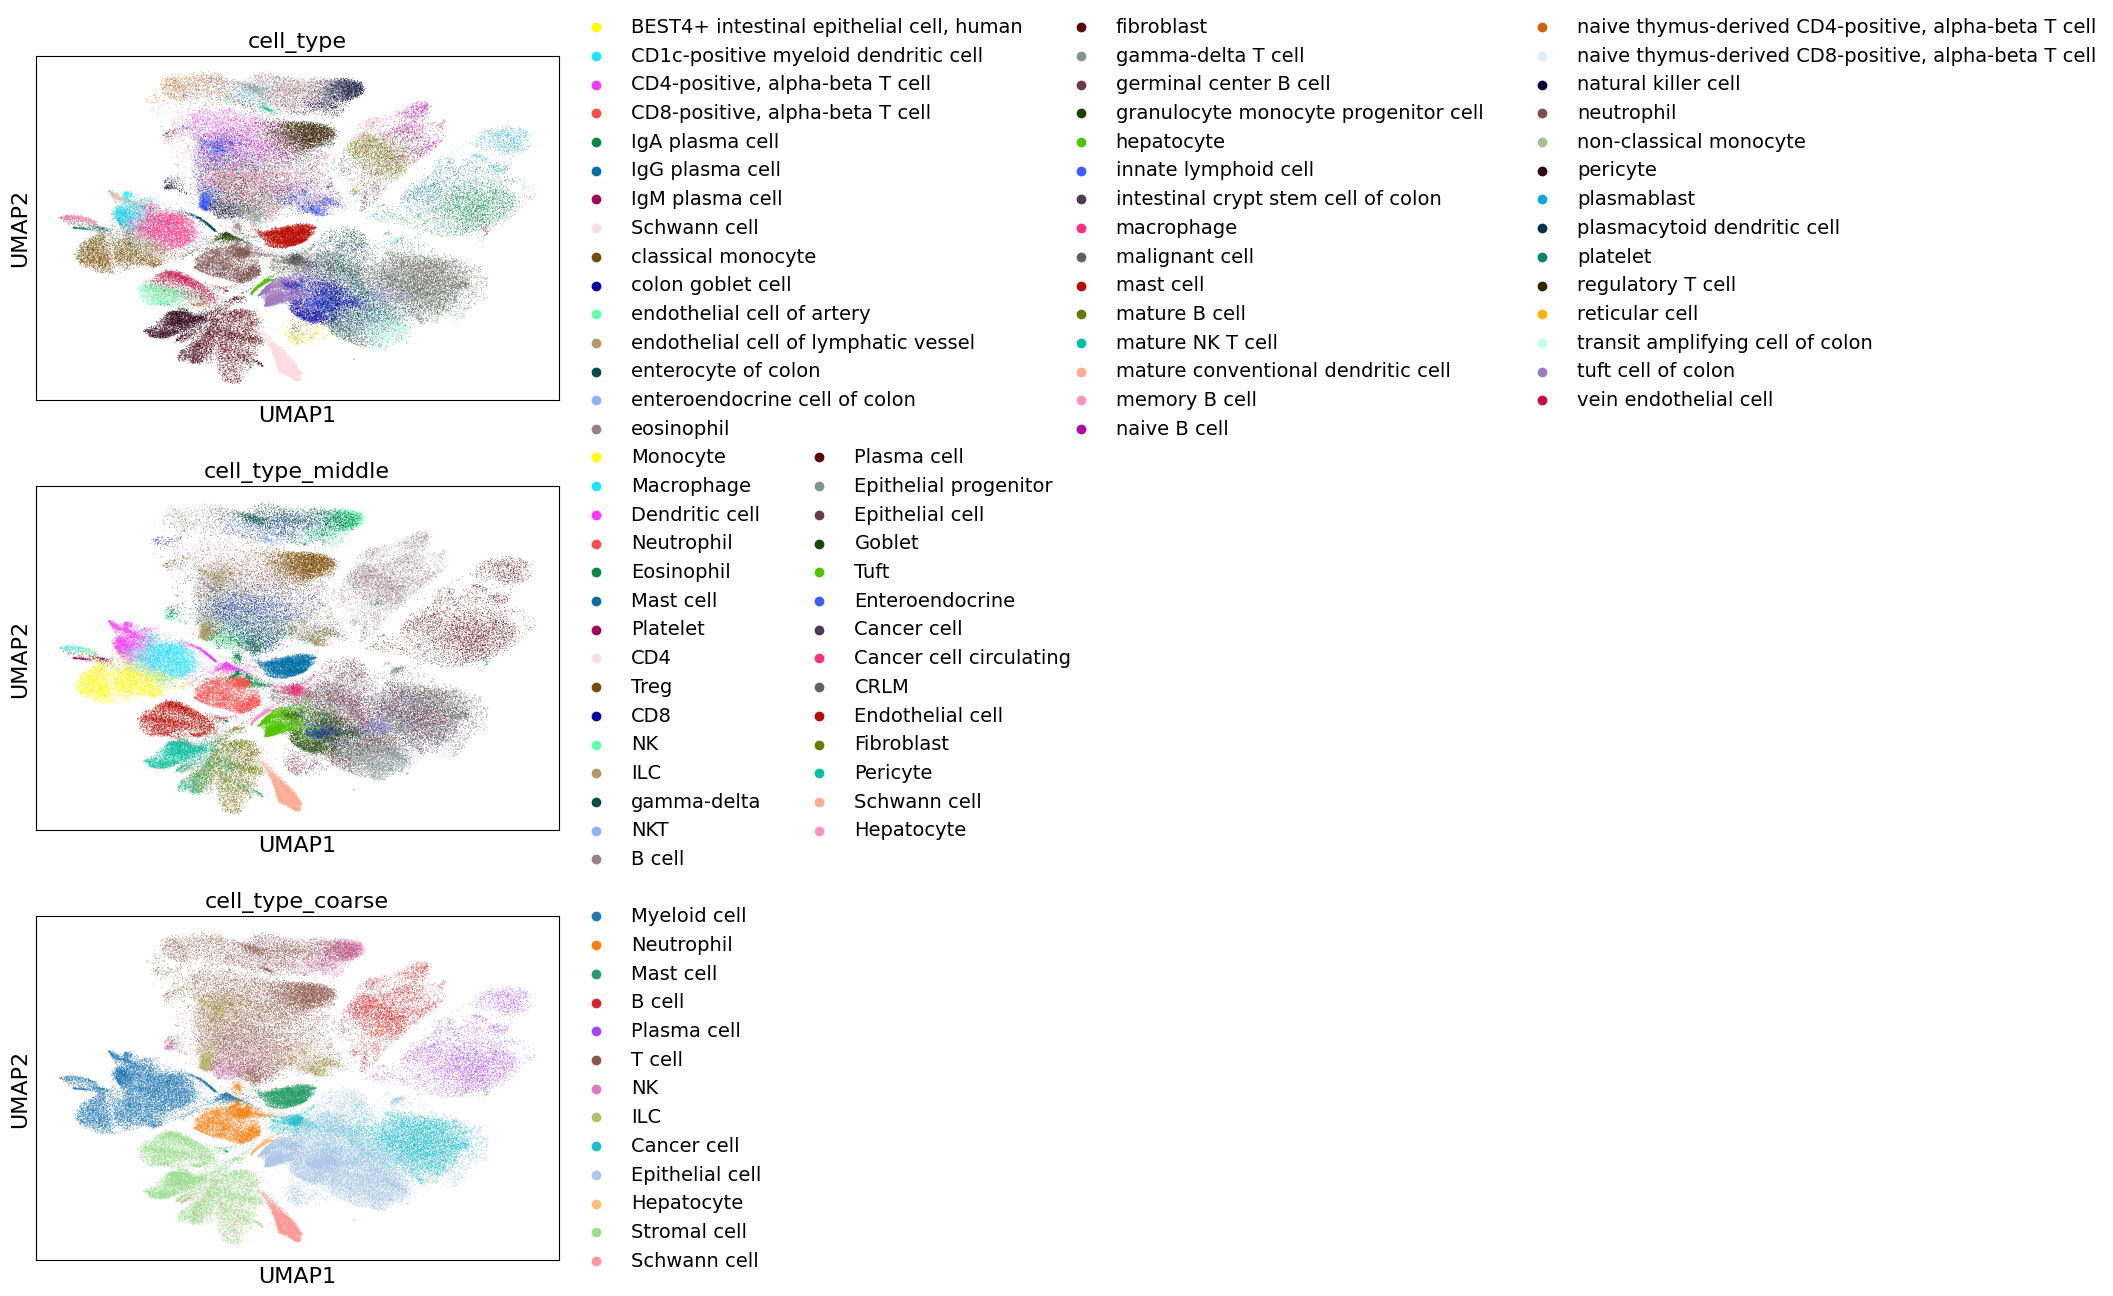

In [17]:
sc.pl.umap(reference, color=["cell_type", "cell_type_middle", "cell_type_coarse"], ncols=1)

## Put the rounded proseg counts into `adata.X`

In [24]:
from scipy.sparse import csr_matrix
from insitupy.plotting import plot_qc_metrics

In [26]:
adata.X = adata.layers["counts"]

In [27]:
adata.X[:5, :5].toarray()

array([[41, 25,  0,  0,  5],
       [ 0,  0,  0,  0,  1],
       [ 0,  0,  1,  3,  2],
       [ 0,  0,  0,  7,  0],
       [ 0,  0,  0,  0,  0]], dtype=uint16)

In [28]:
sc.pp.calculate_qc_metrics(
    adata, percent_top=None, log1p=False, inplace=True
    )

c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


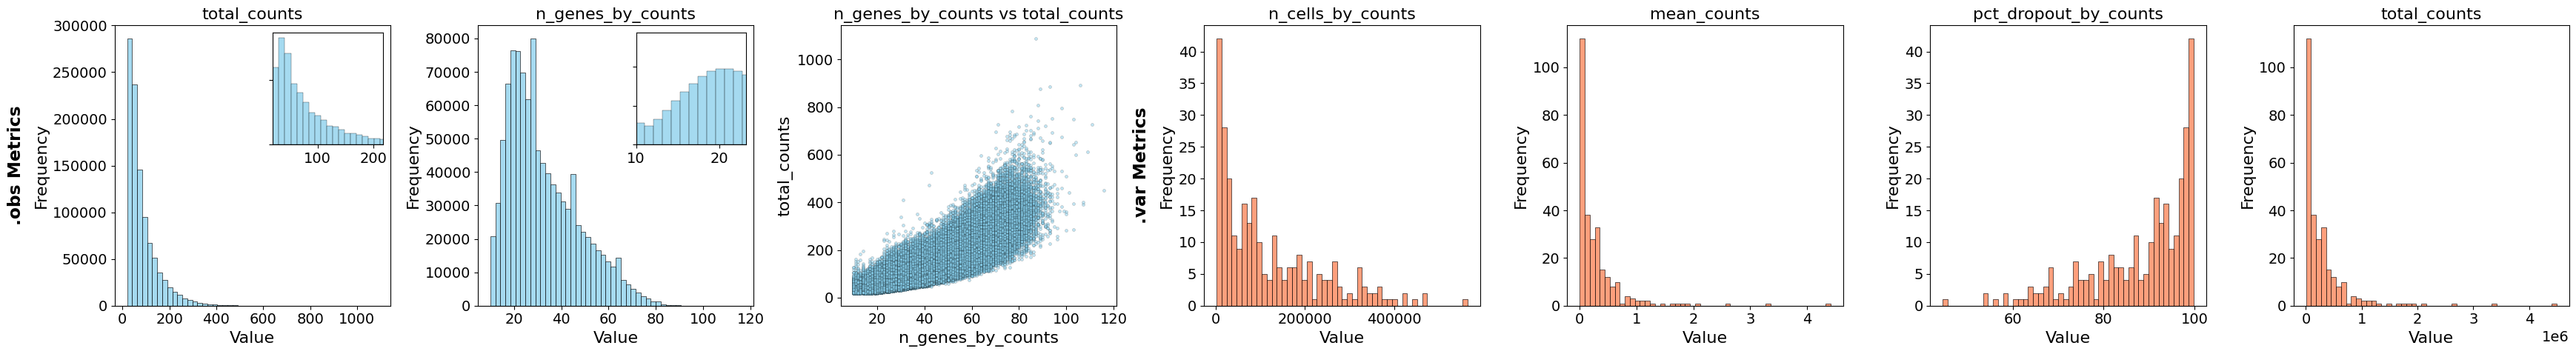

In [29]:
plot_qc_metrics(adata, 0.3)

In [30]:
adata

AnnData object with n_obs × n_vars = 1018411 × 280
    obs: 'original_cell_id', 'centroid_x', 'centroid_y', 'centroid_z', 'fov', 'cluster', 'volume', 'scale', 'population', 'n_genes_by_counts', 'total_counts', 'n_counts', 'n_genes', 'uid'
    var: 'gene_names', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'spatial'
    layers: 'counts'

## Normalize and transform data and reference

In [31]:
from insitupy.preprocessing.anndata import normalize_and_transform_anndata

In [32]:
adata1e2 = adata.copy()
reference1e2 = reference.copy()

c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [33]:
normalize_and_transform_anndata(
    adata=adata1e2, #layer='counts',
    transformation_method='log1p', target_sum=100, scale=False, assert_integer_counts=False
)

Store raw counts in .layers['counts'].
Normalization with target sum 100.
Perform log1p-transformation.


In [34]:
normalize_and_transform_anndata(
    adata=reference1e2, layer='counts', transformation_method='log1p', target_sum=100, scale=False
)

Retrieve raw counts from .layers['counts'].
Normalization with target sum 100.
Perform log1p-transformation.


Save the results.

In [39]:
out_path = adata_path.parent / "celltypist"
out_path.mkdir(exist_ok=True)

In [40]:
adata1e2.write(out_path / "adata_rounded_pp1e2.h5ad")
reference1e2.write(out_path / f"reference_5000_pp1e2.h5ad")

These files are now used in [CRC05a_run_celltypist.py](./CRC05a_run_celltypist.py) to run Celltypist.